# IMPORT

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm   #barres de chargement pour les tâches longues (tracking)
import numpy as np
from google.colab import drive #acces au Drive
import os

from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, log_loss

In [ ]:
drive.mount("/content/drive", force_remount = True)

chemin_audio = 'drive/MyDrive/M2 SID/Last try/Projet non-alternant/Audio/CNN/' #perso
chemin_video = 'drive/MyDrive/M2 SID/Last try/Projet non-alternant/Vidéo/test/' #perso
chemin_texte = 'drive/MyDrive/M2 SID/Last try/Projet non-alternant/Texte/' #perso

Mounted at /content/drive


# INITIALISATION

In [ ]:
df_audio = pd.read_csv(chemin_audio + 'test_predictions_audio.csv')
df_video = pd.read_csv(chemin_video + 'test_predictions_video.csv', sep = ";")
df_texte = pd.read_csv(chemin_texte + 'test_predictions_texte.csv')

In [ ]:
accuracy_audio = (df_audio["true_label"] == df_audio["pred_label"]).mean()
print(f"Accuracy audio : {accuracy_audio * 100:.2f}%")

accuracy_video = (df_video["true_label"] == df_video["pred_label"]).mean()
print(f"Accuracy video : {accuracy_video * 100:.2f}%")

accuracy_texte = (df_texte["true_label"] == df_texte["pred_label"]).mean()
print(f"Accuracy texte : {accuracy_texte * 100:.2f}%")

Accuracy audio : 24.33%
Accuracy video : 50.11%
Accuracy texte : 69.03%


# MISE EN COMMUN DU FORMAT

In [ ]:
class_cols = [
    "music","people","gaming","sports/actions","news/events/politics",
    "education","tv shows","movie/comedy","animation","vehicles/autos",
    "howto","travel","science/technology","animals/pets","kids/family",
    "documentary","food/drink","cooking","beauty/fashion","advertisement"
]

df_audio_video = pd.merge(df_audio[["video_name"] + class_cols], df_video[["video_name"] + class_cols], on = 'video_name', suffixes = ("_audio", "_video"), how = "inner")
df_audio_video_texte = pd.merge(df_audio_video, df_texte, on = 'video_name', how = "inner")

# MOYENNE DES DISTRIBUTIONS

## AUDIO-VIDEO-TEXTE

### Sans pondération

In [ ]:
#construction du dataframe
df_avg = pd.DataFrame()
df_avg["video_name"] = df_audio_video_texte["video_name"]
df_avg["true_label"] = df_audio_video_texte["true_label"]

coef_audio = 1 / 3
coef_video = 1 / 3
coef_texte = 1 / 3

# moyenne des 3 distributions
for col in class_cols:
  df_avg[col] = df_audio_video_texte[f"{col}_audio"] * coef_audio + df_audio_video_texte[f"{col}_video"] * coef_video + df_audio_video_texte[col] * coef_texte

df_avg["pred_label"] = df_avg[class_cols].idxmax(axis = 1)

In [ ]:
accuracy = (df_avg["true_label"] == df_avg["pred_label"]).mean()
print(f"Accuracy : {accuracy * 100:.2f}%")

Accuracy : 62.52847380410023%


Résultat moins bon que la modalité texte individuellement

### Avec pondération

Recherche discrète de coefficients de pondération optimaux (sachant qu'on sait intuitivement qu'un coefficient plus élevé pour la modalité texte sera plus pertinent)

In [ ]:
#recherche des poids
dict_accuracy = dict()
coef_possible = np.linspace(.01, .8, 80)
for coef_audio in tqdm(coef_possible) :
  coef_audio = np.round(coef_audio, 3)
  coef_possible_video = np.linspace(.01, .8 - coef_audio, 10 * int(8 - 10 * coef_audio))
  for coef_video in coef_possible_video :
    coef_video = np.round(coef_video, 3)
    coef_texte = np.round(1 - coef_audio - coef_video, 3)
    for col in class_cols:
      df_avg[col] = df_audio_video_texte[f"{col}_audio"] * coef_audio + df_audio_video_texte[f"{col}_video"] * coef_video + df_audio_video_texte[col] * coef_texte
    df_avg["pred_label"] = df_avg[class_cols].idxmax(axis = 1)
    accuracy = (df_avg["true_label"] == df_avg["pred_label"]).mean()
    dict_accuracy[accuracy] = (coef_audio, coef_video, coef_texte)

  0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
#affichage des meilleures configurations
for key in sorted(dict_accuracy.keys(), reverse = True)[:3] :
  print(f"Accuracy : {float(key) * 100:.2f}% ; coef audio : {dict_accuracy[key][0]} ; coef video : {dict_accuracy[key][1]} ; coef texte : {dict_accuracy[key][2]}")

Accuracy : 69.25% ; coef audio : 0.1 ; coef video : 0.12 ; coef texte : 0.78
Accuracy : 69.21% ; coef audio : 0.04 ; coef video : 0.043 ; coef texte : 0.917
Accuracy : 69.17% ; coef audio : 0.09 ; coef video : 0.122 ; coef texte : 0.788


La pondération est plus efficace donc nous allons utiliser ce système.

Appliquons-le maintenant à toutes les autres combinaisons :

## AUDIO-VIDEO

In [ ]:
df_audio_video = pd.merge(df_audio[["video_name", "true_label"] + class_cols], df_video[["video_name"] + class_cols], on = 'video_name', suffixes = ("_audio", "_video"), how = "inner")

df_avg = pd.DataFrame()
df_avg["video_name"] = df_audio_video["video_name"]
df_avg["true_label"] = df_audio_video["true_label"]

dict_accuracy = dict()
coef_possible = np.linspace(.01, .8, 80)
for coef_audio in tqdm(coef_possible) :
  coef_audio = np.round(coef_audio, 3)
  coef_video = np.round(1 - coef_audio, 3)
  for col in class_cols:
    df_avg[col] = df_audio_video[f"{col}_audio"] * coef_audio + df_audio_video[f"{col}_video"] * coef_video
  df_avg["pred_label"] = df_avg[class_cols].idxmax(axis = 1)
  accuracy = (df_avg["true_label"] == df_avg["pred_label"]).mean()
  dict_accuracy[accuracy] = (coef_audio, coef_video)

for key in sorted(dict_accuracy.keys(), reverse = True)[:3] :
  print(f"Accuracy : {float(key) * 100:.2f}% ; coef audio : {dict_accuracy[key][0]} ; coef video : {dict_accuracy[key][1]}")

  0%|          | 0/80 [00:00<?, ?it/s]

Accuracy : 50.61% ; coef audio : 0.59 ; coef video : 0.41
Accuracy : 50.57% ; coef audio : 0.61 ; coef video : 0.39
Accuracy : 50.53% ; coef audio : 0.62 ; coef video : 0.38


## AUDIO-TEXTE

In [ ]:
df_audio_texte = pd.merge(df_audio[["video_name"] + class_cols], df_texte[["video_name", "true_label"] + class_cols], on = 'video_name', suffixes = ("_audio", "_texte"), how = "inner")

df_avg = pd.DataFrame()
df_avg["video_name"] = df_audio_texte["video_name"]
df_avg["true_label"] = df_audio_texte["true_label"]

dict_accuracy = dict()
coef_possible = np.linspace(.01, .8, 80)
for coef_audio in tqdm(coef_possible) :
  coef_audio = np.round(coef_audio, 3)
  coef_texte = np.round(1 - coef_audio, 3)
  for col in class_cols:
    df_avg[col] = df_audio_texte[f"{col}_audio"] * coef_audio + df_audio_texte[f"{col}_texte"] * coef_texte
  df_avg["pred_label"] = df_avg[class_cols].idxmax(axis = 1)
  accuracy = (df_avg["true_label"] == df_avg["pred_label"]).mean()
  dict_accuracy[accuracy] = (coef_audio, coef_texte)

for key in sorted(dict_accuracy.keys(), reverse = True)[:3] :
  print(f"Accuracy : {float(key) * 100:.2f}% ; coef audio : {dict_accuracy[key][0]} ; coef texte : {dict_accuracy[key][1]}")

  0%|          | 0/80 [00:00<?, ?it/s]

Accuracy : 69.07% ; coef audio : 0.05 ; coef texte : 0.95
Accuracy : 69.03% ; coef audio : 0.07 ; coef texte : 0.93
Accuracy : 68.99% ; coef audio : 0.02 ; coef texte : 0.98


## VIDEO-TEXTE

In [ ]:
df_video_texte = pd.merge(df_video[["video_name"] + class_cols], df_texte[["video_name", "true_label"] + class_cols], on = 'video_name', suffixes = ("_video", "_texte"), how = "inner")

df_avg = pd.DataFrame()
df_avg["video_name"] = df_video_texte["video_name"]
df_avg["true_label"] = df_video_texte["true_label"]

dict_accuracy = dict()
coef_possible = np.linspace(.01, .8, 80)
for coef_video in tqdm(coef_possible) :
  coef_video = np.round(coef_video, 3)
  coef_texte = np.round(1 - coef_video, 3)
  for col in class_cols:
    df_avg[col] = df_video_texte[f"{col}_video"] * coef_video + df_video_texte[f"{col}_texte"] * coef_texte
  df_avg["pred_label"] = df_avg[class_cols].idxmax(axis = 1)
  accuracy = (df_avg["true_label"] == df_avg["pred_label"]).mean()
  dict_accuracy[accuracy] = (coef_video, coef_texte)

for key in sorted(dict_accuracy.keys(), reverse = True)[:3] :
  print(f"Accuracy : {float(key) * 100:.2f}% ; coef video : {dict_accuracy[key][0]} ; coef texte : {dict_accuracy[key][1]}")

  0%|          | 0/80 [00:00<?, ?it/s]

Accuracy : 69.13% ; coef video : 0.14 ; coef texte : 0.86
Accuracy : 69.10% ; coef video : 0.12 ; coef texte : 0.88
Accuracy : 69.06% ; coef video : 0.09 ; coef texte : 0.91


# Comparaison finale des modèles

In [ ]:
dict_accuracy = dict()
dict_accuracy["audio"] = 24.33
dict_accuracy["video"] = 50.11
dict_accuracy["texte"] = 69.03
dict_accuracy["audio_video"] = 50.61
dict_accuracy["audio_texte"] = 69.07
dict_accuracy["video_texte"] = 69.13
dict_accuracy["audio_video_texte"] = 69.25

dict_accuracy = dict(sorted(dict_accuracy.items(), key = lambda x : x[1]))

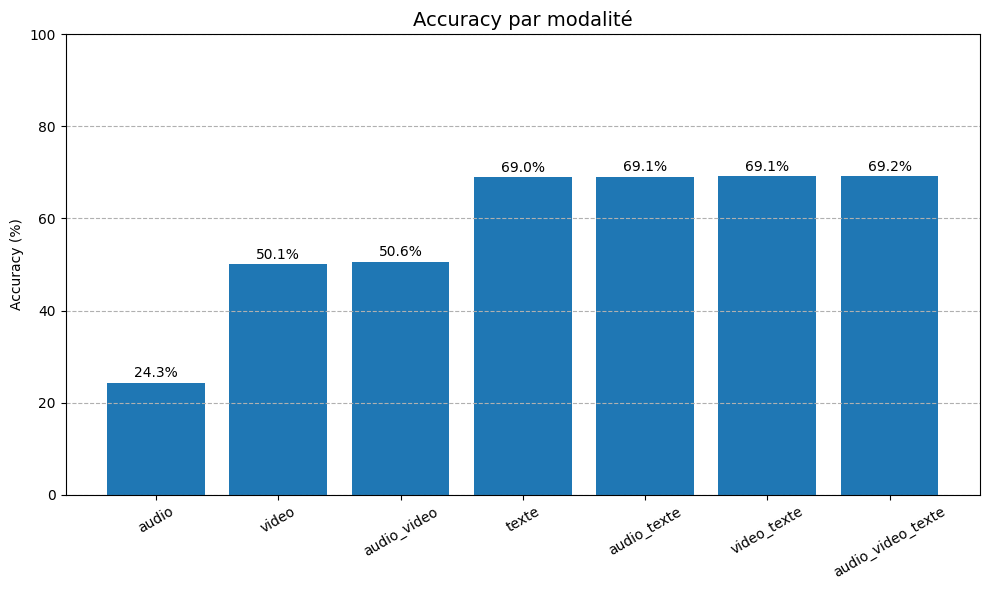

In [ ]:
plt.figure(figsize = (10, 6))
bars = plt.bar(dict_accuracy.keys(), dict_accuracy.values())

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{height:.1f}%", ha = 'center', va = 'bottom', fontsize = 10)

plt.title("Accuracy par modalité", fontsize = 14)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.xticks(rotation = 30)
plt.grid(axis = 'y', linestyle = '--', alpha = 1)
plt.tight_layout()
plt.show()